# Parallel Computing 1: iPyParallel
    Matthew Schaelling
    Math 405
    January 18, 2018

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from ipyparallel import Client
import ipyparallel as ipp

## Problem 1
Initializes a `Client` object, create a `DirectView` with all available engines, and import `scipy.sparse` as `sparse` on all engines.

(This is just to make sure your cluster is running and connected correctly)

In [4]:
from ipyparallel import Client
# make client
client = Client()
num_engines = len(client.ids) # number of engines
dview = client[:]
# import scipy.sparse and numpy in all my engines
dview.execute('import scipy.sparse as sparse')
dview.execute("import numpy as np")

<AsyncResult: execute>

## Problem 2

Write a function `variables(dx)` that accepts a dictionary of variables.
Distribute the variables to all engines, then pull the variables back.

In [5]:
def variables(dx):
    dview.block = True
    # send them variables to the engines
    dview.push(dx)
    return dview.pull(list(dx.keys()))
print(variables({'a':10, 'b':5}))

[[10, 5], [10, 5], [10, 5], [10, 5]]


Thus each engine's variables are correct.

## Problem 3

Write a function that accepts an integer n.
Instruct each engine to make n draws from the standard normal distribution, then hand back the minimum, maximum, and mean draw to the client.
Print the results.

In [12]:
def draw_statistics(n):
    # draw n samples from a standard normal
    dview.execute("samples = np.random.randn({})".format(n))
    # calculate the mean
    dview.execute("means = samples.mean()")
    # calculate the max
    dview.execute("maxs = samples.max()")
    # calculate the min
    dview.execute("mins = samples.min()")
    # return the things I previously calculated
    return [dview['means'], dview['maxs'], dview['mins']]

# do this for 10,000 observations then print them pretty
normal_stats = draw_statistics(10000)
print("means = {0}\nmaxs  = {1}\nmins  = {2}".format(normal_stats[0], 
                                                   normal_stats[1], 
                                                   normal_stats[2]))

means = [-0.0077289346907861503, -0.00038192403238273583, -0.0026275776505726208, -0.011259253957060728]
maxs  = [3.8536869786969081, 3.5667834990636056, 3.8307643123616084, 4.1538970860890734]
mins  = [-3.9690766700698212, -4.1341653939397762, -3.753517470234073, -3.5123954561059398]


## Problem 4

Use `draw_statistics()` to compare serial and parallel execution times.
For $n = 1000000, 5000000, 10000000, 15000000,$
1. Time how long it takes to run your function.
2. Time how long it takes to do the same process (make n draws and calculate and record the statistics) in a for loop with $N$ iterations, where $N$ is the number of engines running.

Plot the execution times against $n$.
You should notice an increase in efficiency in the parallel
version as the problem size increases.

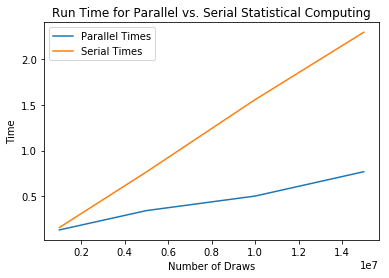

In [7]:
parallel_times = []
serial_times = []
N = [1000000,5000000,10000000,15000000]
for n in N:
    # time how long it takes to do it while parallelizing
    start = time.time()
    draw_statistics(n)
    parallel_times.append(time.time() - start)
    
    # time how long it takes to do it as a noob
    start = time.time()
    for i in range(num_engines):
        samples = np.random.randn(n)
        means = samples.mean()
        maxs = samples.max()
        mins = samples.min()
    serial_times.append(time.time() - start)
    
# plot everything
plt.plot(N, parallel_times, label = 'Parallel Times')
plt.plot(N, serial_times, label = 'Serial Times')
plt.title("Run Time for Parallel vs. Serial Statistical Computing")
plt.ylabel('Time')
plt.xlabel('Number of Draws')
plt.legend()
plt.show()

## Problem 5

Write a function that accepts a function handle $f$ to integrate, bounds of integration, and the number of points to use for the approximation.
Parallelize the trapezoid rule in order to estimate the integral of $f$ over the given bounds.
That is, evenly divide the points among all available processors and run the trapezoid rule on each portion simultaneously.
The sum of the results of all the processors will be the estimation of the integral over the entire interval of integration.
Return this sum.

Demonstrate that your function works.

In [10]:
def trapezoid_parallel(f, a, b, N):
    # create the domain and split it up between engines
    x = np.linspace(a,b,N)
    h = x[1] - x[0]
    # we leave off the last part of the domain because 
    # we add it back on in each engine so we don't lose
    # the space between the separated lists
    dview.scatter("domain", x[:-1])
    dview.push({'h':h})
    dview.execute('domain = np.append(domain, domain[-1] + h)')
    
    # make function to send to each engine that will
    # take the part of the domain in each engine and 
    # estimate the area using the trapezoid rule
    def calc_trapezoid(domain):
        # evaluate the function across the domain
        F = np.apply_along_axis(f,0,domain) 
        # multiply every piece by 2 except the first and last
        # then sum over the values and multiply by h/2
        vect = np.ones_like(domain)
        vect[1:-1] = 2
        return h*.5*np.dot(F,vect)
    
    # sum up the results from each of the engines and return
    return np.sum(dview.apply(calc_trapezoid, 
                              ipp.Reference('domain')))

In [11]:
func = lambda x: 3 * x**2 * np.exp(-x)
trapezoid_parallel(func, -1, 5, 100)

7.4143269532669249

Wolfram Alpha's estimate is 7.4069, so I'm not too far off.